# Micro-Proyecto 3: Aprendizaje Supervisado: Árboles de Decisión - Clasificación Bayesiana

### Integrantes:

* Leonard David Vivas Dallos
* Tomás Escobar Rivera
* Nicolás Orozco Medina

## Contextualización del Problema

Nos encontramos en la siguiente situación. Somos unos investigadores del área de la medicina que hemos recolectado información para realizar un estudio. A lo largo de los años, hemos recolectado cierta información de un conjunto de paciente que sufren la misma enfermedad. Así pues, a lo largo de sus tratamientos, cada paciente respondió a una de 5 medicaciones posibles.

### Objetivo:

Nuestro objetivo será entonces el de construir un modelo capaz de predecir el mejor tratamiento para un futuro paciente con la misma enfermedad. La clasificación objetivo (target) del
tratamiento será una de las siguientes drogas:
* Drug A
* Drug B
* Drug C
* Drug X
* Drug Y

### Dataset:

El conjunto de archivos entregados para este fin son: (drug200_summary.txt, drug200.csv)

Las características (features) de este conjunto de datos son:

* La edad
* El sexo
* La presión arterial
* El colesterol de los pacientes

El objetivo (target) es el medicamento al que respondió cada paciente.

## Importación de las Librerías

In [5]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import Image
from sklearn.tree import plot_tree
from scipy.stats import chi2_contingency
from sklearn.naive_bayes import GaussianNB

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## Preprocesamiento y Exploración de los Datos

### Preprocesamiento

In [6]:
# Cargar datos
dataset = pd.read_csv('drug200.csv')
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [7]:
print("Dimensiones del dataset:", dataset.shape)

Dimensiones del dataset: (200, 6)


Nuestro dataset consta de 200 datos (líneas de información), cada una con 6 atributos (5 características y 1 clasificación). A primera vista, vemos algunos datos categóricos que deberemos mapear a datos numéricos para trabajar de mejor manera. Revisemos columna por columna y vayamos realizando el procesamiento adecuado.

In [8]:
print(dataset.groupby('Age').size())

Age
15    3
16    3
17    1
18    3
19    2
20    4
21    1
22    5
23    7
24    4
25    1
26    4
28    7
29    2
30    1
31    4
32    6
33    1
34    4
35    3
36    4
37    5
38    3
39    6
40    3
41    4
42    4
43    4
45    4
46    2
47    8
48    2
49    7
50    5
51    4
52    2
53    3
54    1
55    2
56    4
57    4
58    5
59    3
60    5
61    4
62    2
63    1
64    3
65    4
66    2
67    4
68    4
69    3
70    3
72    4
73    2
74    4
dtype: int64


Nuestra primer característica es la edad ('Age'), que en principio no necesita preprocesamiento alguno. Más adelante revisaremos su distribución con respecto a la clasificación.

In [9]:
print(dataset.groupby('Sex').size())

Sex
F     96
M    104
dtype: int64


Nos encontramos con la características 'Sex', característica categórica que apriori esta balanceada en los datos que tenemos. Realicemos un mapeo de la misma de la siguiente manera:

* F (Femenino) --> 0
* M (Masculino) --> 1

In [10]:
dataset['Sex'] = dataset['Sex'].map({'F': 0, 'M': 1})
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,HIGH,HIGH,25.355,drugY
1,47,1,LOW,HIGH,13.093,drugC
2,47,1,LOW,HIGH,10.114,drugC
3,28,0,NORMAL,HIGH,7.798,drugX
4,61,0,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,0,LOW,HIGH,11.567,drugC
196,16,1,LOW,HIGH,12.006,drugC
197,52,1,NORMAL,HIGH,9.894,drugX
198,23,1,NORMAL,NORMAL,14.020,drugX


In [11]:
print(dataset.groupby('BP').size())

BP
HIGH      77
LOW       64
NORMAL    59
dtype: int64


Ahora tenemos la categoría 'BP' o 'Blood Pressure', que hace referencia a la presión en la sangre de los pacientes, es una característica categórica que también está bastante balanceada. Hagamos un mapeo de la misma de la siguiente manera.

* Low --> 0
* Normal --> 1
* High --> 2

In [12]:
dataset['BP'] = dataset['BP'].map({'LOW': 0, 'NORMAL': 1, 'HIGH': 2})
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,HIGH,25.355,drugY
1,47,1,0,HIGH,13.093,drugC
2,47,1,0,HIGH,10.114,drugC
3,28,0,1,HIGH,7.798,drugX
4,61,0,0,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,0,0,HIGH,11.567,drugC
196,16,1,0,HIGH,12.006,drugC
197,52,1,1,HIGH,9.894,drugX
198,23,1,1,NORMAL,14.020,drugX


In [13]:
print(dataset.groupby('Cholesterol').size())

Cholesterol
HIGH      103
NORMAL     97
dtype: int64


Ahora, tenemos el nivel de colesterol del paciente ('Cholesterol'), otra variable categórica que nuevamente, a primera vista parece bastante balanceada. Realicemos su mapeo de la siguiente manera:

* Normal --> 0
* High --> 1

In [14]:
dataset['Cholesterol'] = dataset['Cholesterol'].map({'NORMAL': 0, 'HIGH': 1})
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,25.355,drugY
1,47,1,0,1,13.093,drugC
2,47,1,0,1,10.114,drugC
3,28,0,1,1,7.798,drugX
4,61,0,0,1,18.043,drugY
...,...,...,...,...,...,...
195,56,0,0,1,11.567,drugC
196,16,1,0,1,12.006,drugC
197,52,1,1,1,9.894,drugX
198,23,1,1,0,14.020,drugX


Adicionalmente, tenemos la característica 'Na_to_K', que ya se encuentra en un formato indicado para trabajar con ella.

Finalmente, nos encontramos la clasificación de la droga recetada a cada paciente. Procedemos a mapearla también para un mejor manejo de la misma.

In [15]:
print(dataset.groupby('Drug').size())

Drug
drugA    23
drugB    16
drugC    16
drugX    54
drugY    91
dtype: int64


Es un target que en principio parece bastante desbalanceado. Haremos su mapeo de la siguiente manera:
* Drug A --> 0
* Drug B --> 1
* Drug C --> 2
* Drug X --> 3
* Drug Y --> 4

In [16]:
dataset['Drug'] = dataset['Drug'].map({'drugA': 0, 'drugB': 1, 'drugC': 2, 'drugX': 3, 'drugY': 4})
dataset

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,2,1,25.355,4
1,47,1,0,1,13.093,2
2,47,1,0,1,10.114,2
3,28,0,1,1,7.798,3
4,61,0,0,1,18.043,4
...,...,...,...,...,...,...
195,56,0,0,1,11.567,2
196,16,1,0,1,12.006,2
197,52,1,1,1,9.894,3
198,23,1,1,0,14.020,3


Según parece, ya tenemos un dataset con el cual podemos trabajar de manera acorde. Procedamos entonces a realizar un análisis de las distribuciones de la variable objetivo y de cuál es su relación con el resto de variables.

### Exploración de los datos

En principio, veamos cual es la distribución de la variable objetivo.

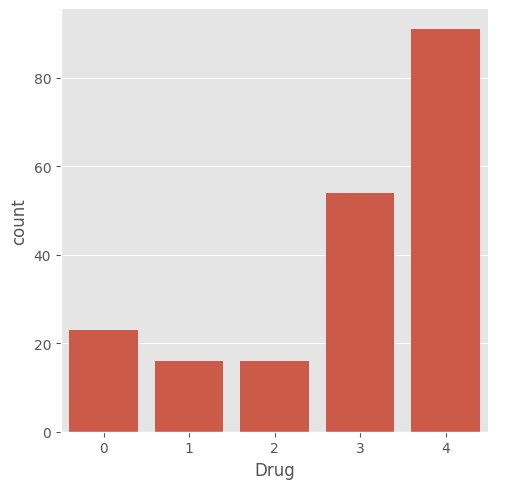

In [17]:
# Distribución de la variable objetivo
sb.catplot(x = 'Drug', data = dataset, kind = 'count')

In [18]:
print(dataset.groupby('Drug').size())

Drug
0    23
1    16
2    16
3    54
4    91
dtype: int64


Como podemos ver, la distribución de la variable objetivo en nuestros datos es bastante dispareja, podemos notar una presencia notoria de la droga 4 (Drug Y) y de la droga 3 (Drug X) por encima del resto.

Ahora, veamos como se distribuyen las variables categóricas según la droga suministrada

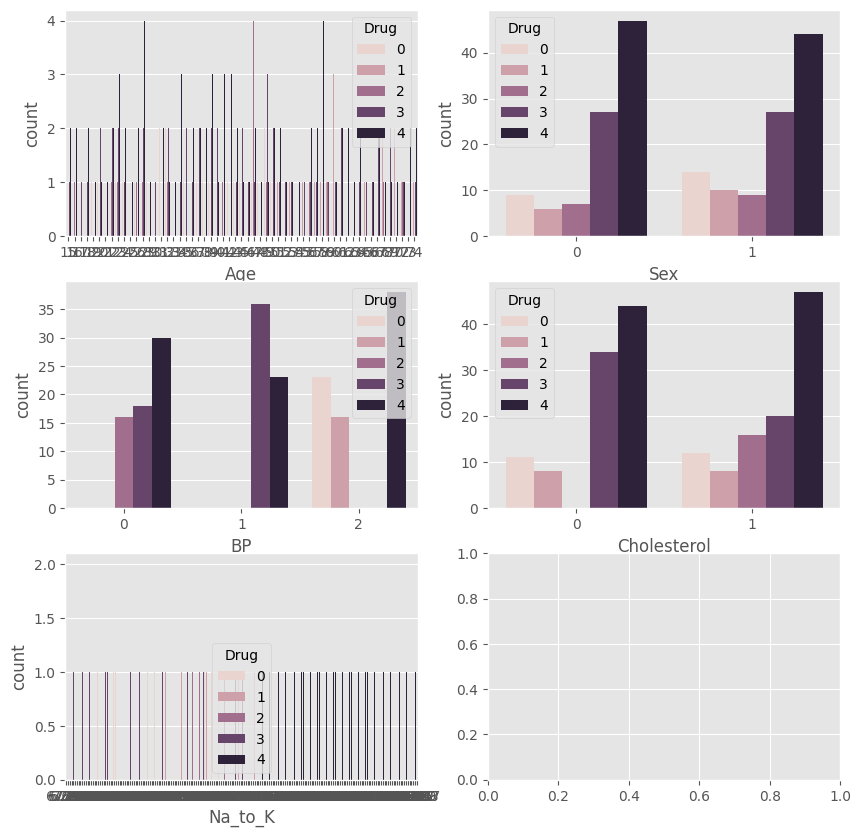

In [19]:
dataset_cols = dataset.columns.to_list()
dataset_cols.remove('Drug')

_, ax = plt.subplots(3, 2, figsize=(10, 10))

ax = ax.flatten()

for i, col in enumerate(dataset_cols):
    sb.countplot(data=dataset, x=col, ax=ax[i], hue='Drug')

plt.show()

Esta visualización puede ser útil para características como el sexo, la presión de sangre y el colesterol, pero no para el resto. Veamos otra visualización a ver si mejora.

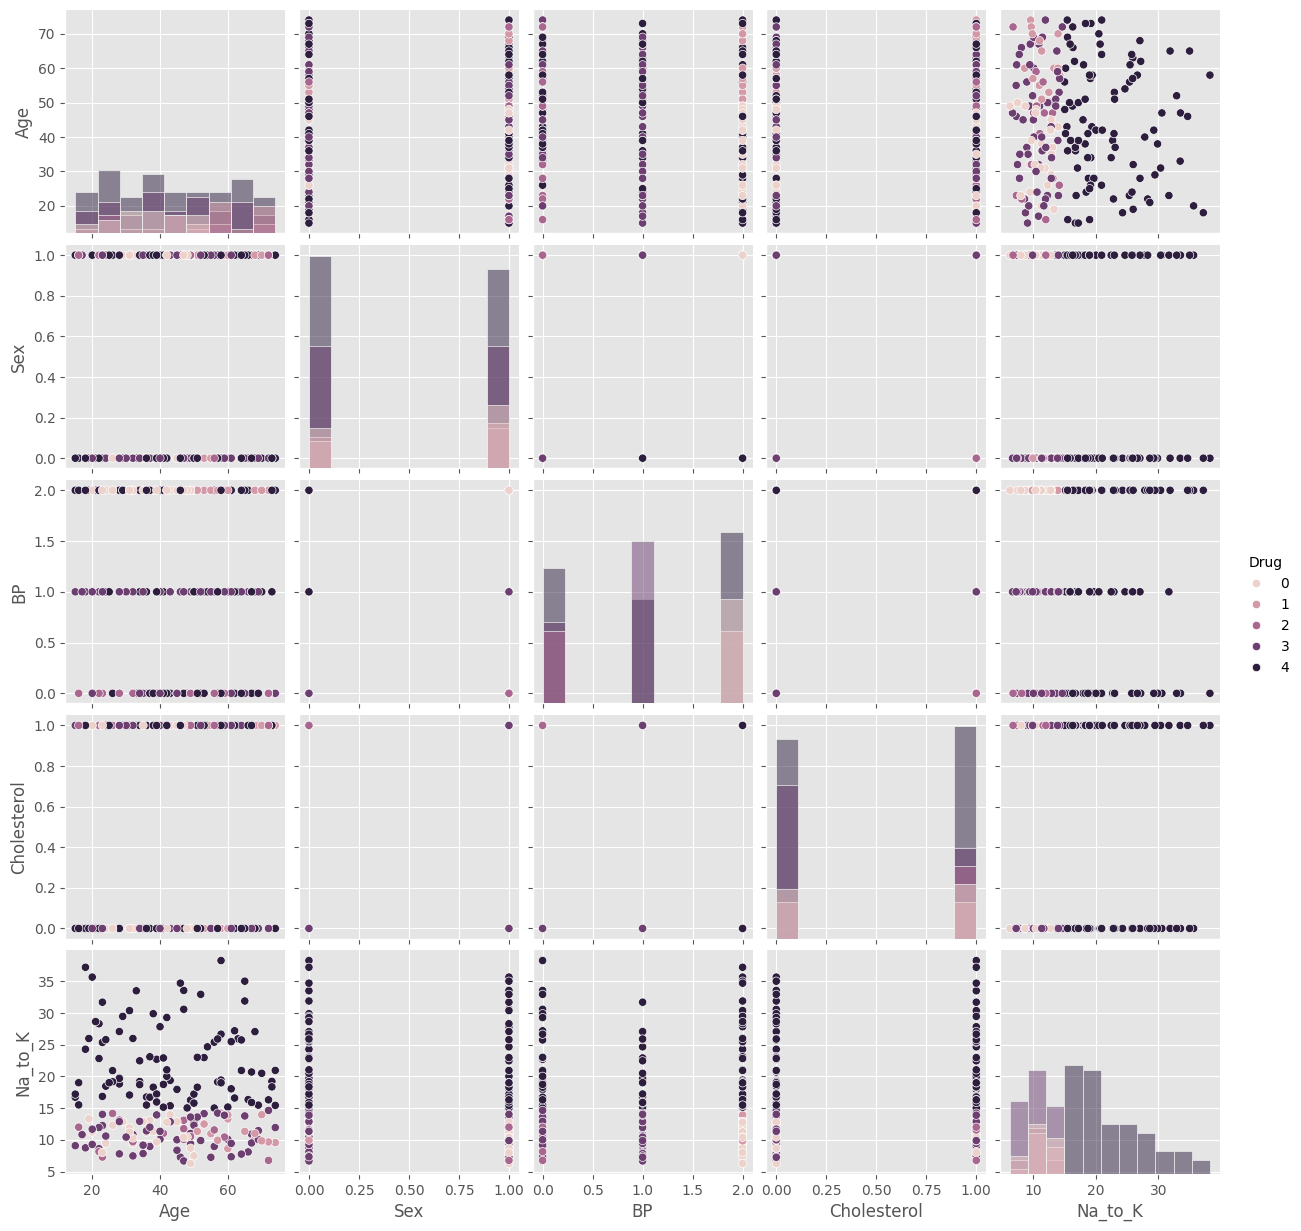

In [20]:
sb.pairplot(dataset, hue='Drug', diag_kind='hist')

Como parte final de nuestro preprocesamiento, dividamos nuestros datos entre características objetivo y características a usar en nuestro entrenamiento.

In [21]:
#Todos los datos excepto la caracteristica objetivo.
dataset.dropna(inplace=True)

dataset = dataset.sample(frac=1).reset_index(drop=True)

X = dataset.drop(['Drug'], axis=1)

#CARACTERÍSTICA OBJETIVO
y = dataset['Drug']

## Entropía vs Gini

In [22]:
# Gini vs Entropy
criteria = ['gini', 'entropy']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = list()
max_attributes = len(list((dataset)))
depth_range = range(1, max_attributes + 1)


results = {'gini': [], 'entropy': []}

for criterion in criteria:
    for depth in depth_range:
        scores = []
        for train_idx, val_idx in cv.split(X, y):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

            clf = DecisionTreeClassifier(
                criterion=criterion,
                max_depth=depth,
                random_state=42
            )
            clf.fit(X_train_cv, y_train_cv)
            score = clf.score(X_val_cv, y_val_cv)
            scores.append(score)

        results[criterion].append(np.mean(scores))

### Visualización Gini

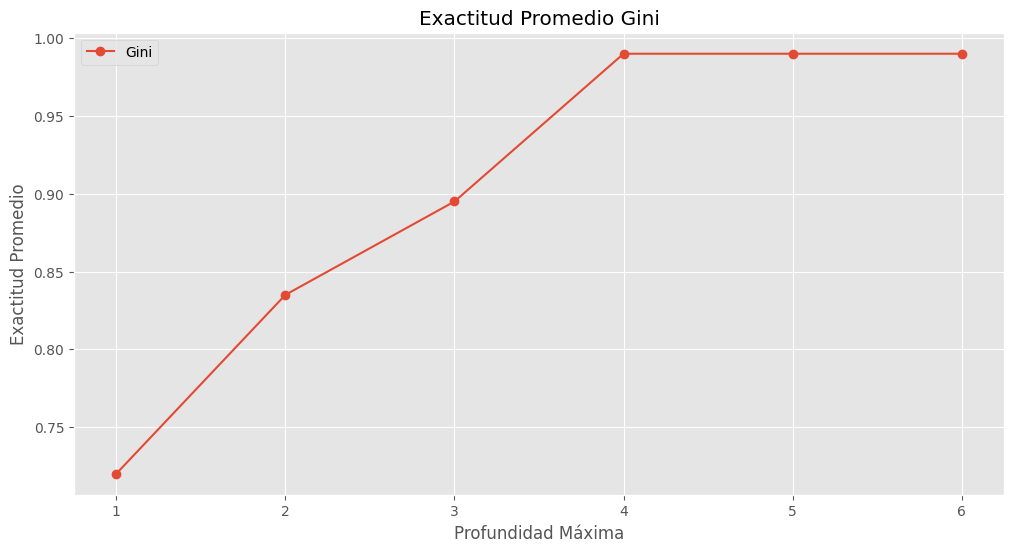

Gini:
Profundidad: 1, Exactitud Promedio: 0.7200
Profundidad: 2, Exactitud Promedio: 0.8350
Profundidad: 3, Exactitud Promedio: 0.8950
Profundidad: 4, Exactitud Promedio: 0.9900
Profundidad: 5, Exactitud Promedio: 0.9900
Profundidad: 6, Exactitud Promedio: 0.9900


In [23]:
plt.figure(figsize=(12, 6))
plt.plot(depth_range, results['gini'], marker='o', label='Gini')
plt.xlabel('Profundidad Máxima')
plt.ylabel('Exactitud Promedio')
plt.title('Exactitud Promedio Gini')
plt.legend()
plt.grid(True)
plt.show()

# Resultados Gini
print("Gini:")
for depth, score in zip(depth_range, results['gini']):
    print(f"Profundidad: {depth}, Exactitud Promedio: {score:.4f}")

### Visualización Entropía

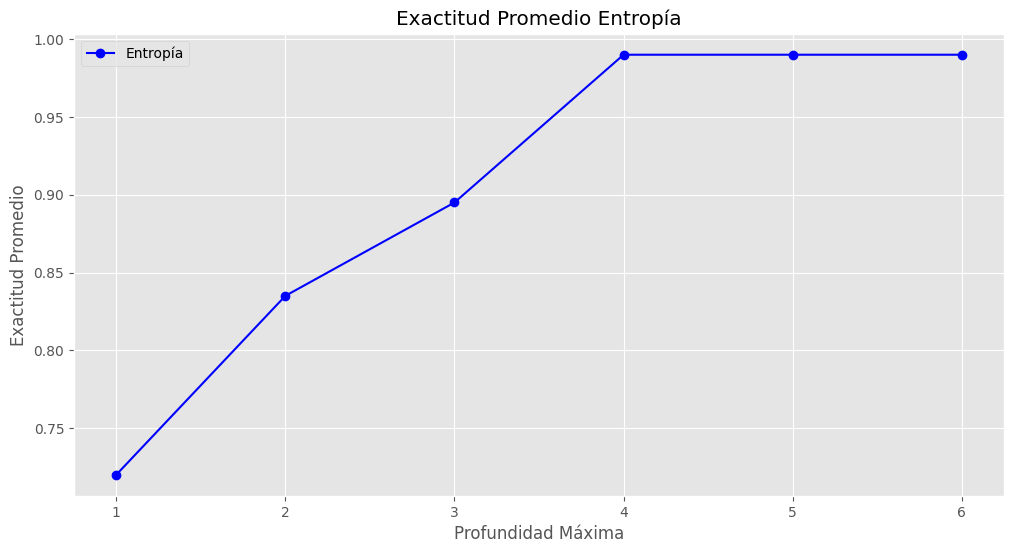

Entropía:
Profundidad: 1, Exactitud Promedio: 0.7200
Profundidad: 2, Exactitud Promedio: 0.8350
Profundidad: 3, Exactitud Promedio: 0.8950
Profundidad: 4, Exactitud Promedio: 0.9900
Profundidad: 5, Exactitud Promedio: 0.9900
Profundidad: 6, Exactitud Promedio: 0.9900


In [24]:
# Visualización Entropía
plt.figure(figsize=(12, 6))
plt.plot(depth_range, results['entropy'], marker='o', label='Entropía', color='blue')
plt.xlabel('Profundidad Máxima')
plt.ylabel('Exactitud Promedio')
plt.title('Exactitud Promedio Entropía')
plt.legend()
plt.grid(True)
plt.show()

# Resultados Entropía
print("Entropía:")
for depth, score in zip(depth_range, results['entropy']):
    print(f"Profundidad: {depth}, Exactitud Promedio: {score:.4f}")

### Mejor Criterio

In [25]:
# Determinar el mejor criterio y profundidad
best_criterion = max(results.items(), key=lambda x: max(x[1]))[0]
best_depth = depth_range[np.argmax(results[best_criterion])]

print(f"\nMejor criterio: {best_criterion}")
print(f"Mejor profundidad: {best_depth}")
print(f"Mejor exactitud: {max(results[best_criterion]):.4f}")


Mejor criterio: gini
Mejor profundidad: 4
Mejor exactitud: 0.9900


Como podemos evidenciar en el análisis anterior, los criterios Gini y Entropía tienen un comportamiento igual entre si, obteniendo los mismos resultados. Sin embargo, usaremos la característica Gini, con una profundidad de 4 para el mismo, esto nos permitirá obtener una exactitud bastante buena, con un 0.9900 de efectividad.

## Porcentaje de Datos Entrenamiento vs Prueba

Para determinar la cantidad de datos que deberíamos usar en nuestro modelo para entrenamiento y que tanta deberíamos usar para prueba, creamos algunos árboles en una "vista previa" que nos permita ver los valores de exactitud que recibirán cada uno de los datos. De igual manera, cabe destacar que estos NO son árboles definitivos y serán usado solo para determinar la distribución de los porcentajes de los datos.

### Distribución 90/10 (Entrenamiento / Prueba)

In [26]:
#Todos los datos excepto la caracteristica comprar
X_9 = dataset.drop(['Drug'], axis=1)

#Atributo OBJETIVO
y_9 = dataset['Drug']

# Dividimos los datos para entrenamiento y prueba
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(X_9, y_9,
                                                    test_size = 0.1, #90% datos de entrenamiento, 10% prueba
                                                    stratify = y_9,
                                                    random_state = 1)
# Datos de entrenaminto
conteo_9 = X_train_9.copy()
conteo_9['label'] = y_train_9
conteo_9.groupby('label').size()

,0
label,
0,21
1,14
2,14
3,49
4,82


In [27]:
decision_tree_9 = DecisionTreeClassifier(criterion='gini',
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree_9.fit(X_train_9, y_train_9)
y_pred_train_9 = decision_tree_9.predict(X_train_9)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train_9 = accuracy_score(y_train_9, y_pred_train_9)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train_9))

y_pred_test_9 = decision_tree_9.predict(X_test_9)

#Porcentaje de Exactitud con pruebas
acc_test_9 = accuracy_score(y_test_9, y_pred_test_9)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test_9))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


### Distribución 80/20 (Entrenamiento / Prueba)

In [28]:
#Todos los datos excepto la caracteristica comprar
X_8 = dataset.drop(['Drug'], axis=1)

#Atributo OBJETIVO
y_8 = dataset['Drug']

# Dividimos los datos para entrenamiento y prueba
X_train_8, X_test_8, y_train_8, y_test_8 = train_test_split(X_8, y_8,
                                                    test_size = 0.2, #80% datos de entrenamiento, 20% prueba
                                                    stratify = y_8,
                                                    random_state = 1)
# Datos de entrenaminto
conteo_8 = X_train_8.copy()
conteo_8['label'] = y_train_8
conteo_8.groupby('label').size()

,0
label,
0,18
1,13
2,13
3,43
4,73


In [29]:
decision_tree_8 = DecisionTreeClassifier(criterion='gini',
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree_8.fit(X_train_8, y_train_8)
y_pred_train_8 = decision_tree_8.predict(X_train_8)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train_8 = accuracy_score(y_train_8, y_pred_train_8)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train_8))

y_pred_test_8 = decision_tree_8.predict(X_test_8)

#Porcentaje de Exactitud con pruebas
acc_test_8 = accuracy_score(y_test_8, y_pred_test_8)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test_8))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


### Distribución 70/30 (Entrenamiento / Prueba)

In [30]:
#Todos los datos excepto la caracteristica comprar
X_7 = dataset.drop(['Drug'], axis=1)

#Atributo OBJETIVO
y_7 = dataset['Drug']

# Dividimos los datos para entrenamiento y prueba
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7,
                                                    test_size = 0.3, #70% datos de entrenamiento, 30% prueba
                                                    stratify = y_7,
                                                    random_state = 1)
# Datos de entrenaminto
conteo_7 = X_train_7.copy()
conteo_7['label'] = y_train_7
conteo_7.groupby('label').size()

,0
label,
0,16
1,11
2,11
3,38
4,64


In [31]:
decision_tree_7 = DecisionTreeClassifier(criterion='gini',
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree_7.fit(X_train_7, y_train_7)
y_pred_train_7 = decision_tree_7.predict(X_train_7)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train_7 = accuracy_score(y_train_7, y_pred_train_7)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train_7))

y_pred_test_7 = decision_tree_7.predict(X_test_7)

#Porcentaje de Exactitud con pruebas
acc_test_7 = accuracy_score(y_test_7, y_pred_test_7)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test_7))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


### Distribución 60/40 (Entrenamiento / Prueba)

In [32]:
#Todos los datos excepto la caracteristica comprar
X_6 = dataset.drop(['Drug'], axis=1)

#Atributo OBJETIVO
y_6 = dataset['Drug']

# Dividimos los datos para entrenamiento y prueba
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_6, y_6,
                                                    test_size = 0.4, #60% datos de entrenamiento, 40% prueba
                                                    stratify = y_6,
                                                    random_state = 1)
# Datos de entrenaminto
conteo_6 = X_train_6.copy()
conteo_6['label'] = y_train_6
conteo_6.groupby('label').size()

,0
label,
0,14
1,10
2,9
3,32
4,55


In [33]:
decision_tree_6 = DecisionTreeClassifier(criterion='gini',
                                             max_depth = depth,
                                             class_weight='balanced')

# Ajustamos el modelo con los datos
decision_tree_6.fit(X_train_6, y_train_6)
y_pred_train_6 = decision_tree_6.predict(X_train_6)

#Porcentaje de Exactitud con los datos de entrenamiento
acc_train_6 = accuracy_score(y_train_6, y_pred_train_6)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train_6))

y_pred_test_6 = decision_tree_6.predict(X_test_6)

#Porcentaje de Exactitud con pruebas
acc_test_6 = accuracy_score(y_test_6, y_pred_test_6)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test_6))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


### Conclusión

Como podemos evidenciar, apriori, la división de los datos que más nos beneficia en términos de exactitud en los entrenamientos, es una división 90/10, obteniendo resultados bastantes impresionantes y con increíble exactitud de los datos.

In [34]:
X_F = dataset.drop(['Drug'], axis=1)

#Atributo OBJETIVO
y_F = dataset['Drug']

# Dividimos los datos para entrenamiento y prueba
X_train_F, X_test_F, y_train_F, y_test_F = train_test_split(X_F, y_F,
                                                    test_size = 0.1, #90% datos de entrenamiento, 10% prueba
                                                    stratify = y_F,
                                                    random_state = 1)

## Decisión de las Variables a Usar

### Gráfico de Pearson

<Axes: title={'center': 'Pearson Correlation of Features'}>

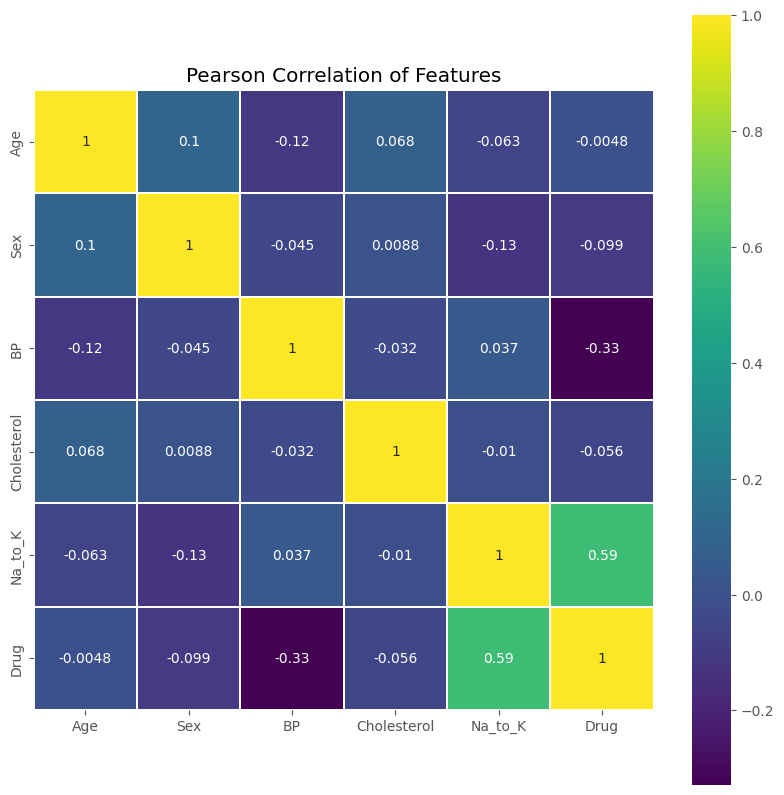

In [35]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features')
sb.heatmap(dataset.astype(float).corr(),
           vmax=1.0,
           cmap=colormap,
           annot=True,
           linewidths=0.1,
           linecolor='white',
           square=True)

### Gráfico de Cramer V

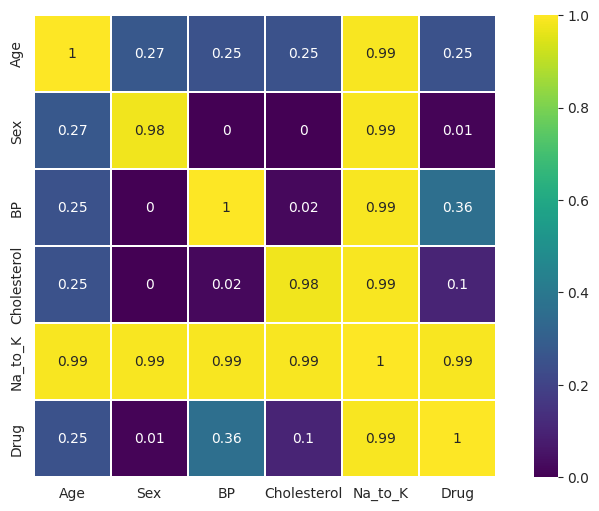

In [36]:
data_encoded = dataset.copy()

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab)
  mini = min(crosstab.shape) - 1
  return (stat/(obs*mini))

rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2])
    col.append(round(cramers,2))
  rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)
with sb.axes_style("white"):
  ax = sb.heatmap(df,
                  vmin=0.,
                  vmax=1,
                  cmap=colormap,
                  annot=True,
                  linewidths=0.1,
                  square=True)

plt.show()

### SelectKBest

In [37]:
# SelectKBest
selector = SelectKBest(f_classif, k='all')
selector.fit(X_F, y_F)

# Obtener scores
scores = pd.DataFrame({
    'Feature': X_F.columns,
    'Score': selector.scores_
})
scores = scores.sort_values('Score', ascending=False)

print("Importancia de características:")
print(scores)

Importancia de características:
       Feature      Score
4      Na_to_K  85.611356
2           BP  37.414443
0          Age   7.210544
3  Cholesterol   5.299457
1          Sex   0.522099


### Conclusión

Como podemos ver por los distintos métodos de clasificación y análisis de las características, la característica que más influye en la decisión del tratamiento a seguir y por ende, la característica más importante en nuestro análisis es la característica "Na_to_K", la cual, con diferencia al resto, resulta bastante determinante.

Además de esto, la presión en la sangre "BP" tambien tiene una gran importancia en nuestros datos, obteniendo el segundo puntaje más alto.

En principio, podríamos decir que estas dos características deberían ser aquellas seleccionadas para continuar con nuestro análisis, pues resultan con diferencia al resto, tener gran importancia en los datos.

Cabe destacar que la característica del Sexo resulta casi de importancia nula, mientras que características como la Edad y/o el Colesterol, a pesar de que no son de mucha importancia, están ahí por si pueden llegar a servir para análisis mucho más detallados.

## Análisis Exactitud a Distintos Niveles del Árbol

Tal cual mencionamos anteriormente, las variables a usar entonces serán:
* Na_to_k
* BP

Procederemos entonces a evaluar la exactitud que tendría el árbol a distintos niveles teniendo en cuenta estas características

In [38]:
# Definimos nuestro dataset filtrado
dataset_def = dataset.drop(['Age', 'Cholesterol', 'Sex'], axis=1)

dataset_def

,BP,Na_to_K,Drug
0,1,8.750,3
1,0,10.067,2
2,1,15.171,4
3,0,13.598,3
4,0,22.697,4
...,...,...,...
195,0,15.015,4
196,2,18.457,4
197,0,11.767,2
198,1,9.514,3


In [39]:
X_def = dataset_def.drop(['Drug'], axis=1)
y_def = dataset_def['Drug']

In [40]:
#Para usar este método X y 'y' deben ser listas np
X_def=np.array(X_def)
y_def=np.array(y_def)

cv_def = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
accuracies_def = list()
max_attributes = len(list(dataset))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
    for train_index, valid_index in cv.split(X_def, y_def):
        X_train, X_test = X_def[train_index], X_def[valid_index]
        y_train, y_test = y_def[train_index], y_def[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies_def.append(avg)

# Mostramos los resultados obtenidos
df_def = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies_def})
df_def = df_def[["Max Depth", "Average Accuracy"]]
print(df_def.to_string(index=False))

 Max Depth  Average Accuracy
         1              0.69
         2              0.80
         3              0.80
         4              0.79
         5              0.81
         6              0.81


Según estos resultados y usando estas variables, podemos ver que una profundidad de 3 genera una exactitud de aproximadamente 0.8, lo cual resulta ser bueno. Sin embargo, revisaremos si usando las otras características que tenían un impacto relativo podemos lograr una mejora de las exactitudes obtenidas.

In [41]:
dataset_def2 = dataset.drop(['Sex'], axis=1)

X_def2 = dataset_def2.drop(['Drug'], axis=1)
y_def2 = dataset_def2['Drug']

#Para usar este método X y 'y' deben ser listas np
X_def2=np.array(X_def2)
y_def2=np.array(y_def2)

cv_def2 = StratifiedKFold(n_splits=6, shuffle=True, random_state=1)
accuracies_def2 = list()
max_attributes = len(list(dataset))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = DecisionTreeClassifier(criterion='gini',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight='balanced')
    for train_index, valid_index in cv.split(X_def2, y_def2):
        X_train, X_test = X_def2[train_index], X_def2[valid_index]
        y_train, y_test = y_def2[train_index], y_def2[valid_index]

        model = tree_model.fit(X_train, y_train)
        valid_acc = model.score(X_test, y_test) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    # almacenamos acc promedio para cada profundidad
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies_def2.append(avg)

# Mostramos los resultados obtenidos
df_def2 = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies_def2})
df_def2 = df_def2[["Max Depth", "Average Accuracy"]]
print(df_def2.to_string(index=False))

 Max Depth  Average Accuracy
         1              0.69
         2              0.80
         3              0.87
         4              0.99
         5              0.99
         6              0.99


Como podemos ver, usar las otras dos características que tienen un impacto algo bajo pero que sigue siendo importante resulta en una mejora significativa para nuestros resultados. En nuestro caso, con una profundidad de 4, obtenemos una exactitud promedio de 0.99, lo cual es bastante mejor a la obtenida anteriormente, por lo que nos iremos por esta aproximación.

## Balanceo y Entrenamiento

Comencemos con instanciar nuestra división de los datos en un 90/10, con nuestras características escogidas.

In [42]:
X_E = dataset_def2.drop(['Drug'], axis=1)
y_E = dataset_def2['Drug']

# Impresion de las características seleccionadas
print("Características seleccionadas:")
print(X_E.columns)

# Dividimos los datos para entrenamiento y prueba
X_train_E, X_test_E, y_train_E, y_test_E = train_test_split(X_E, y_E,
                                                    test_size = 0.1,
                                                    stratify = y_E,
                                                    random_state = 1)

Características seleccionadas:
Index(['Age', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')


In [43]:
conteo_E = X_train_E.copy()
conteo_E['label'] = y_train_E
conteo_E.groupby('label').size()

,0
label,
0,21
1,14
2,14
3,49
4,82


Como pudimos ver, los datos no están balanceados, por lo que será prudente balancearlos. Además, tendremos un árbol con altura de 4. Variemos el número de muestras mínimas por nodo y por hojas para ver que exactitudes obtenemos y tomar una decisión para poder formalizar nuestro árbol.

### Árbol con mínimo de muestras 5 y mínimo de hojas 2

In [44]:
decision_tree_E1 = DecisionTreeClassifier(criterion='gini',
                                            min_samples_split=5,
                                            min_samples_leaf=2,
                                            max_depth = 4,
                                            class_weight='balanced')

In [45]:
# Ajustamos el modelo con los datos
decision_tree_E1.fit(X_train_E, y_train_E)

#Cada cambio que se haga requiere analizar o tener en cuenta su nivel de exactitud.
#Exactitud

#Datos de entrenamiento
y_pred_train_E1 = decision_tree_E1.predict(X_train_E)

#Porcentaje de exactitud con los datos de entrenamiento
acc_train_E1 = accuracy_score(y_train_E, y_pred_train_E1)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train_E1))

#Datos de prueba
y_pred_test_E1 = decision_tree_E1.predict(X_test_E)

#Porcentaje de exactitud con pruebas
acc_test_E1 = accuracy_score(y_test_E, y_pred_test_E1)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test_E1))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


### Árbol con mínimo de muestras 10 y mínimo de hojas 5

In [46]:
decision_tree_E2 = DecisionTreeClassifier(criterion='gini',
                                            min_samples_split=10,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight='balanced')

In [47]:
# Ajustamos el modelo con los datos
decision_tree_E2.fit(X_train_E, y_train_E)

#Cada cambio que se haga requiere analizar o tener en cuenta su nivel de exactitud.
#Exactitud

#Datos de entrenamiento
y_pred_train_E2 = decision_tree_E2.predict(X_train_E)

#Porcentaje de exactitud con los datos de entrenamiento
acc_train_E2 = accuracy_score(y_train_E, y_pred_train_E2)
print("Exactitud con datos de entrenamiento: {:.2f}".format(acc_train_E2))

#Datos de prueba
y_pred_test_E2 = decision_tree_E2.predict(X_test_E)

#Porcentaje de exactitud con pruebas
acc_test_E2 = accuracy_score(y_test_E, y_pred_test_E2)
print("Exactitud con datos de pruebas: {:.2f}".format(acc_test_E2))

Exactitud con datos de entrenamiento: 1.00
Exactitud con datos de pruebas: 1.00


### Árbol final

Como podemos ver, no se obtienen cambios, y desde el principio se obtienen resultados bastantes deseados, por lo que mantendremos un mínimo de muestras por nodo de 5 y un mínimo de hojas de 2.

In [48]:
decision_tree_E = DecisionTreeClassifier(criterion='gini',
                                            min_samples_split=5,
                                            min_samples_leaf=2,
                                            max_depth = 4,
                                            class_weight='balanced')

decision_tree_E.fit(X_train_E, y_train_E)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=2,
                       min_samples_split=5)

Visualicemos el árbol de decisión que tenemos

In [49]:
# Imprimo las listas de características y etiquetas
feature_names_E = X_E.columns
print("Características:", feature_names_E)

num_classes_E = len(decision_tree_E.classes_)
class_names_E = [str(x) for x in decision_tree_E.classes_]
print("Etiquetas:", class_names_E)

Características: Index(['Age', 'BP', 'Cholesterol', 'Na_to_K'], dtype='object')
Etiquetas: ['0', '1', '2', '3', '4']


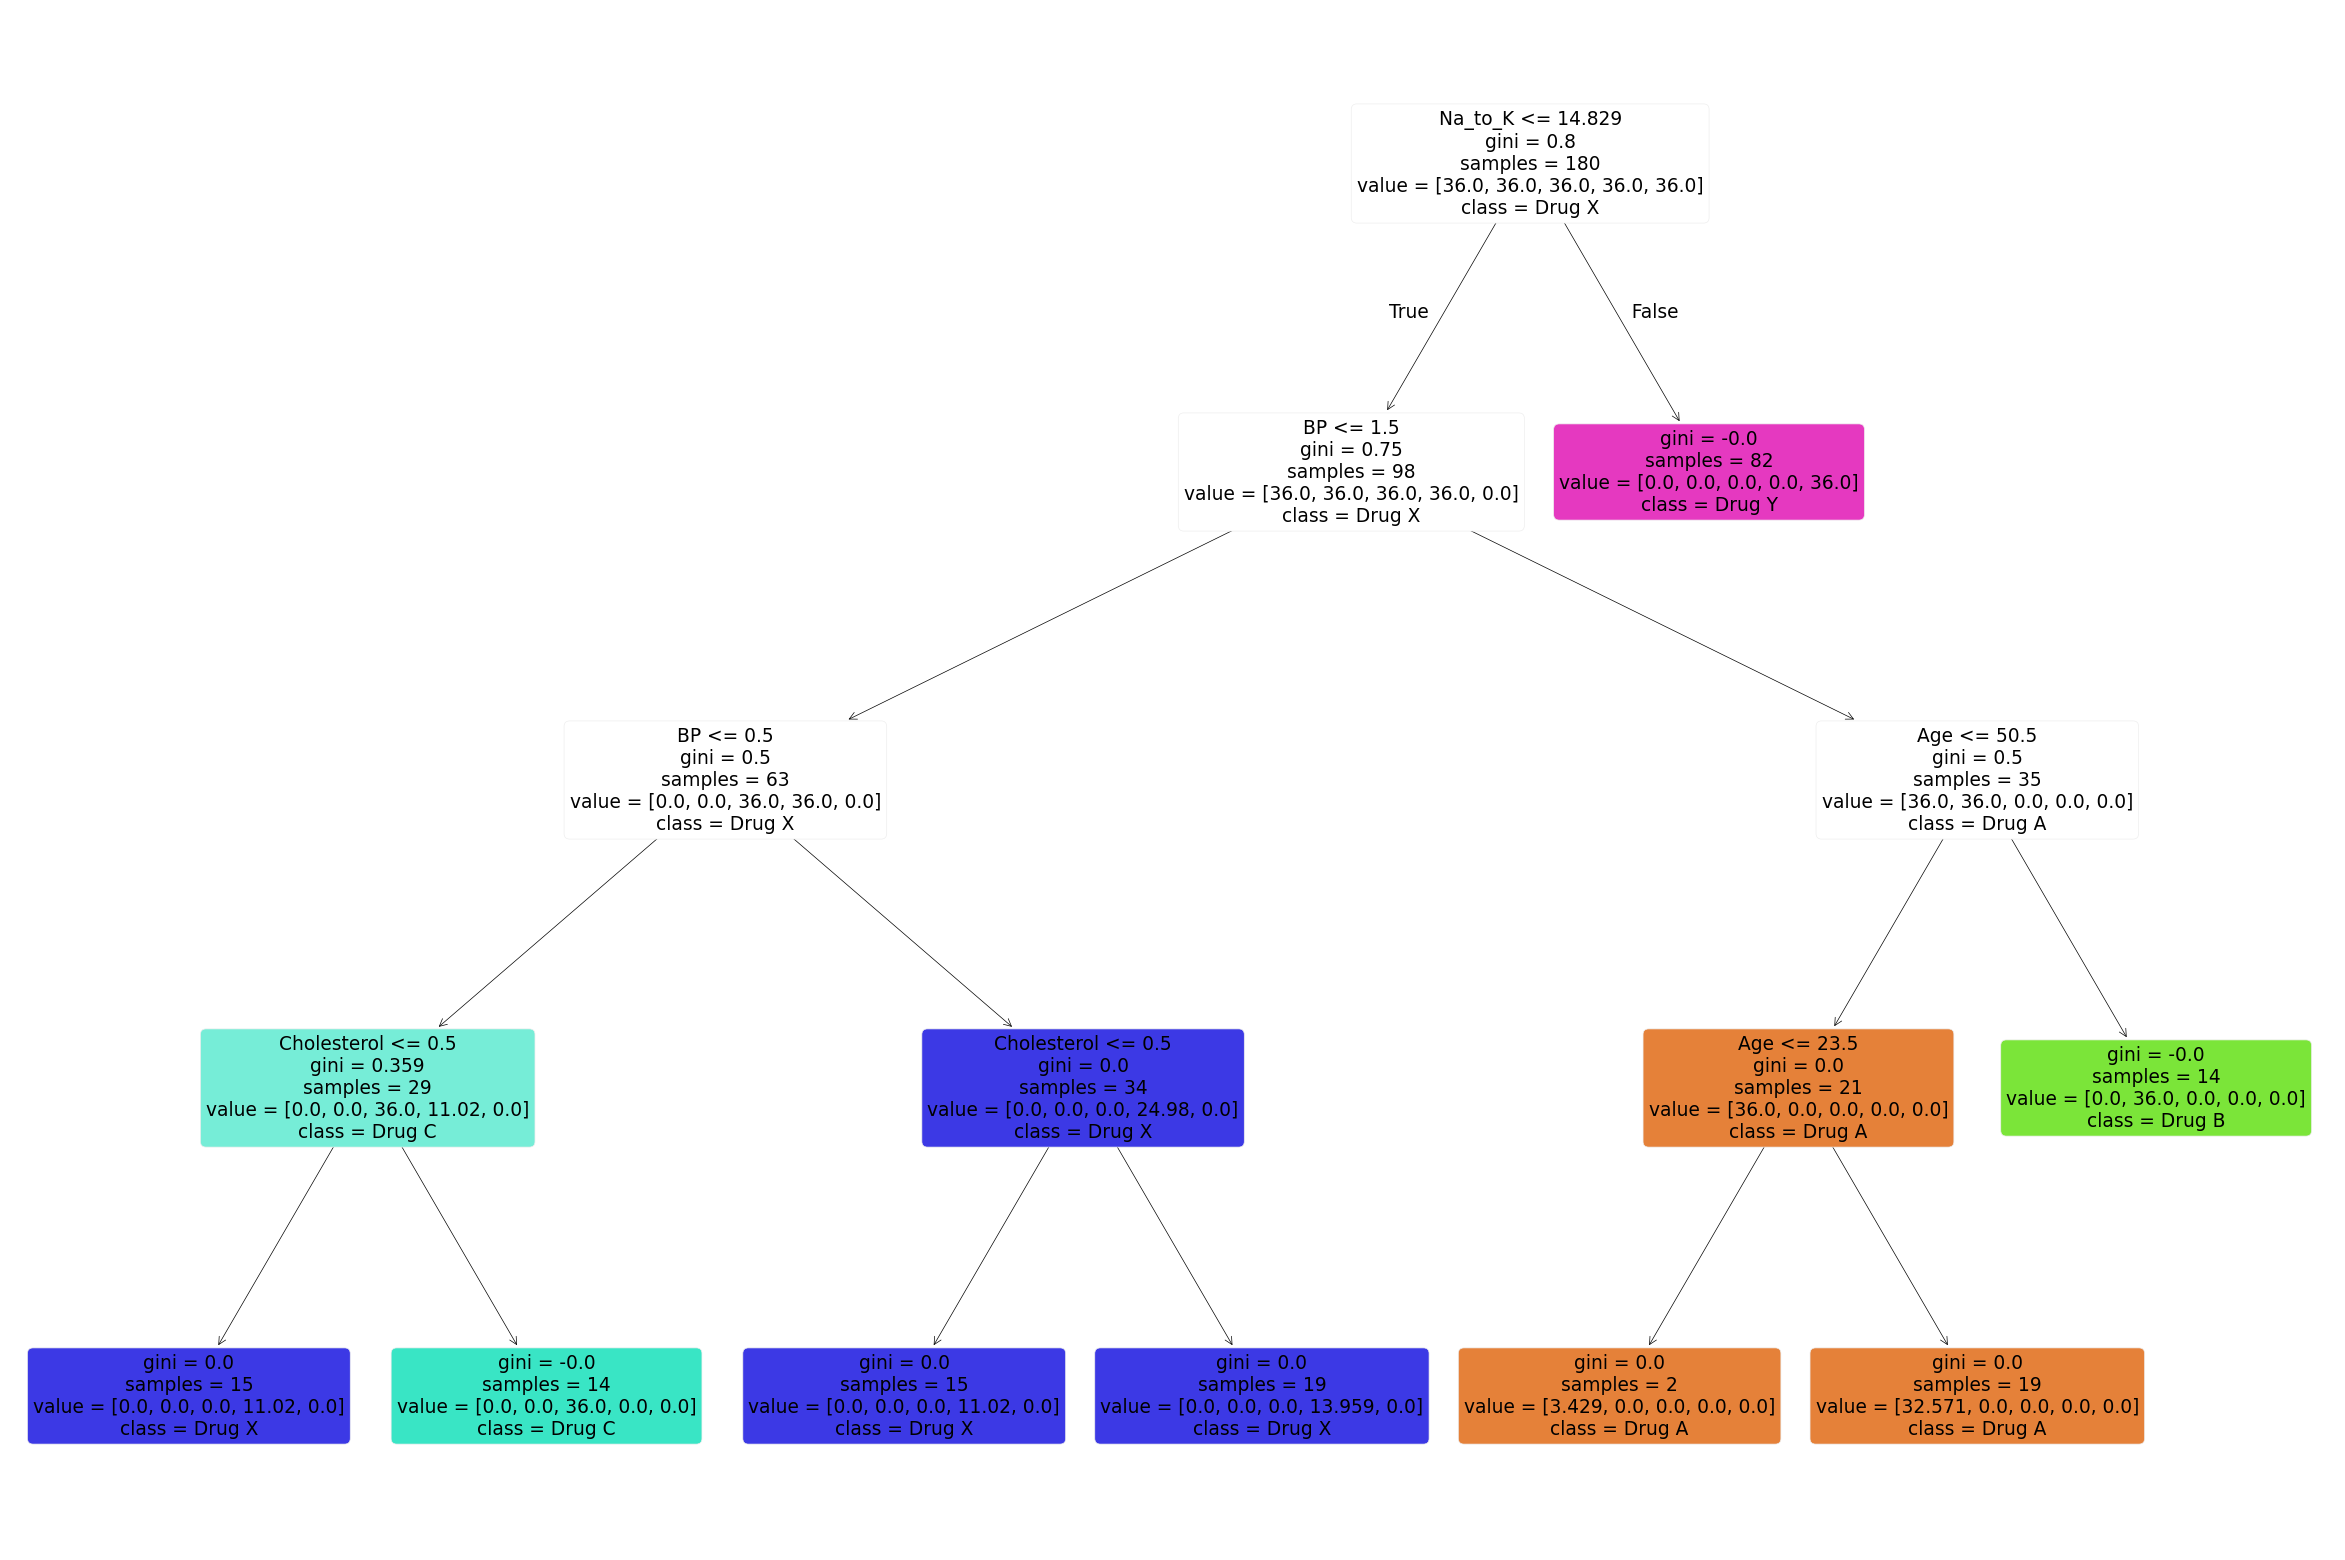

In [50]:
plt.figure(figsize=(30,20))
plot_tree(decision_tree_E,
          feature_names=X_E.columns.tolist(),
          class_names=['Drug A', 'Drug B', 'Drug C', 'Drug X', 'Drug Y'],
          filled=True,
          rounded=True)
plt.show()

## Matriz de Confusión

En este paso, generaremos la matriz de confusión obtenida para nuestra selección de conjuntos de entrenamiento y prueba. Para esto, primero tengamos en cuenta la siguiente notación:

* tp (True positive): Valor que es verdad y que el modelo predijo correctamente.
* fn (False negative): Valor que es verdad y el modelo predijo incorrectamente.
* fp (False positive): Valor que no es verdad y que el modelo predijo incorrectamente.
* tn (True negative): Valor que no es verdad y que el modelo predijo correctamente.

### Matriz para Entrenamiento

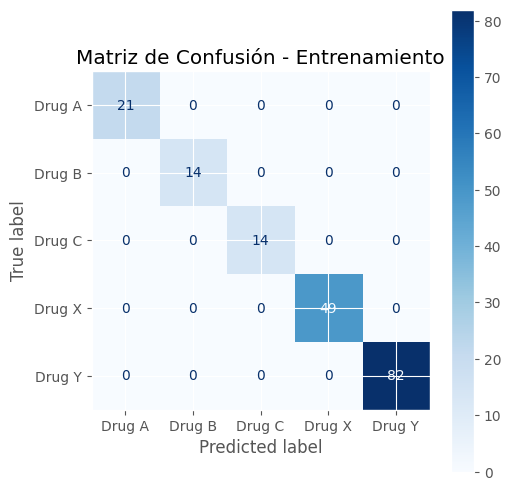

In [51]:
# Crear plot
plt.figure(figsize=(12, 6))

# Matriz de confusión - Datos de entrenamiento
ConfusionMatrixDisplay.from_estimator(
    decision_tree_E, X_train_E, y_train_E,
    display_labels=['Drug A', 'Drug B', 'Drug C', 'Drug X', 'Drug Y'],
    cmap='Blues',
    ax=plt.subplot(1, 2, 1)
)
plt.title("Matriz de Confusión - Entrenamiento")

plt.show()

### Matriz para Prueba

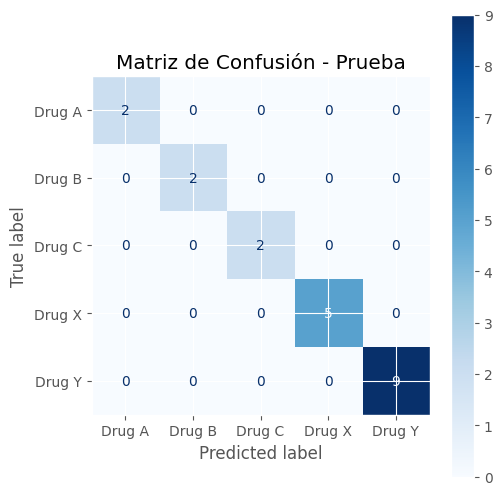

In [52]:
# Crear plot
plt.figure(figsize=(12, 6))

# Matriz de confusión - Datos de entrenamiento
ConfusionMatrixDisplay.from_estimator(
    decision_tree_E, X_test_E, y_test_E,
    display_labels=['Drug A', 'Drug B', 'Drug C', 'Drug X', 'Drug Y'],
    cmap='Blues',
    ax=plt.subplot(1, 2, 1)
)
plt.title("Matriz de Confusión - Prueba")

plt.show()

### Conclusión

Como podemos notar en las matrices de confusión, nuestras predicciones resultaron ser bastante acordes a lo esperado, obtuvimos una exactitud del 100%, sin denotar errores en las mismas. Además, tal cual como se veía en la distribución de los datos, existe una mayor tendencia a clasificar la "Drug Y" por encima del resto, esto puede ser debido a temas netamente médicos de mayor aceptación.

## Métrica de Exactitud

### Métrica de Exactitud del Entrenamiento

In [53]:
y_pred_train = decision_tree_E.predict(X_train_E)
acc_train = accuracy_score(y_train_E, y_pred_train)
print("Train set accuracy: {:.2f}".format(acc_train))

Train set accuracy: 1.00


### Métrica de Exactitud de la Prueba

In [54]:
y_pred_test = decision_tree_E.predict(X_test_E)
acc_test = accuracy_score(y_test_E, y_pred_test)
print("Test set accuracy: {:.2f}".format(acc_test))

Test set accuracy: 1.00


## Métricas de Presición

### Métricas de Precisión del Entrenamiento

In [55]:
decoded_y_test = y_train_E
decoded_predictions = decision_tree_E.predict(X_train_E)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test,
                            decoded_predictions))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        82

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



### Métricas de Precisión de la Prueba

In [56]:
decoded_y_test2 = y_test_E
decoded_predictions2 = decision_tree_E.predict(X_test_E)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test2,
                            decoded_predictions2))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



## Clasificación Bayesiana

Procedamos entonces a realizar los análisis de la clasificación Bayesiana, para posteriormente comparar sus resultados con los análisis previos

In [57]:
#Ajustando el modelo
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train_E,
    y_train_E
)
y_pred = gnb.predict(X_test_E)

print('Accuracy in training set: {:.2f}'
     .format(gnb.score(X_train_E, y_train_E)))
print('Accuracy in test set: {:.2f}'
     .format(gnb.score(X_test_E, y_test_E)))

Accuracy in training set: 0.89
Accuracy in test set: 0.90


### Matriz de Confusión

#### Para el Entrenamiento

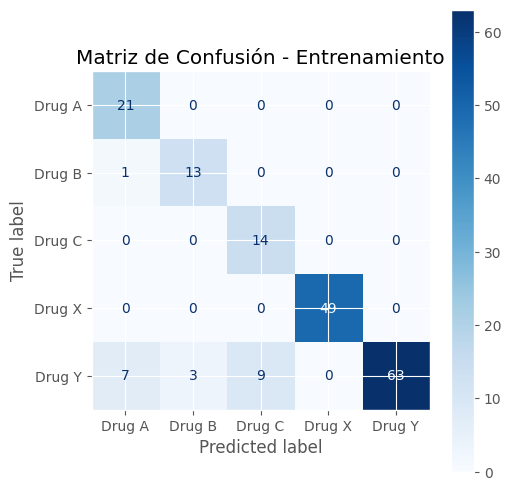

In [58]:
# Crear plot
plt.figure(figsize=(12, 6))

# Matriz de confusión - Datos de entrenamiento
ConfusionMatrixDisplay.from_estimator(
    gnb, X_train_E, y_train_E,
    display_labels=['Drug A', 'Drug B', 'Drug C', 'Drug X', 'Drug Y'],
    cmap='Blues',
    ax=plt.subplot(1, 2, 1)
)
plt.title("Matriz de Confusión - Entrenamiento")

plt.show()

#### Para la Prueba

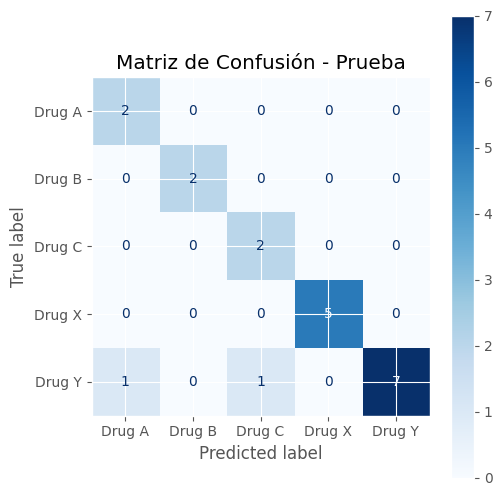

In [59]:
# Crear plot
plt.figure(figsize=(12, 6))

# Matriz de confusión - Datos de entrenamiento
ConfusionMatrixDisplay.from_estimator(
    gnb, X_test_E, y_test_E,
    display_labels=['Drug A', 'Drug B', 'Drug C', 'Drug X', 'Drug Y'],
    cmap='Blues',
    ax=plt.subplot(1, 2, 1)
)
plt.title("Matriz de Confusión - Prueba")

plt.show()

### Métricas de Precisión (F1-Score)

#### Para el Entrenamiento

In [60]:
decoded_y_test_B = y_train_E
decoded_predictions_B = gnb.predict(X_train_E)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test_B,
                            decoded_predictions_B))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        21
           1       0.81      0.93      0.87        14
           2       0.61      1.00      0.76        14
           3       1.00      1.00      1.00        49
           4       1.00      0.77      0.87        82

    accuracy                           0.89       180
   macro avg       0.83      0.94      0.87       180
weighted avg       0.92      0.89      0.89       180



#### Para la Prueba


In [61]:
decoded_y_test2_B = y_test_E
decoded_predictions2_B = gnb.predict(X_test_E)
print(f'Reporte de clasificación:')
print(classification_report(decoded_y_test2_B,
                            decoded_predictions2_B))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         5
           4       1.00      0.78      0.88         9

    accuracy                           0.90        20
   macro avg       0.87      0.96      0.89        20
weighted avg       0.93      0.90      0.90        20



## Análisis de los Resultados

Como pudimos evidenciar, apriori, los resultados obtenidos por la Clasificación Bayesiana, a pesar de ser bastante buenos, no logran igualar los que tuvimos con el análisis del árbol, veamos un poco más a detalle esto.

### Árbol

In [62]:
# Crear un nuevo DataFrame para los pacientes desconocidos
x_test = pd.DataFrame(columns=('Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'))

# Ejemplo 1
x_test.loc[0] = (50, 1, 2, 1, 15.0, 0)  # El último valor 'Drug' es el que se va a predecir y no importa en este caso

# Ejemplo 2
x_test.loc[1] = (55, 0, 1, 0, 13.5, 0)

# Ejemplo 3
x_test.loc[2] = (65, 1, 2, 1, 20.0, 0)

# Ejemplo 4
x_test.loc[3] = (40, 0, 0, 0, 11.0, 0)

# Eliminar la columna 'Sex' para que coincida con las características utilizadas durante el ajuste del modelo
x_test = x_test.drop(['Sex'], axis=1)

# Realizar las predicciones con el árbol de decisión
y_pred_tree = decision_tree_E.predict(x_test.drop(['Drug'], axis=1))  # Saca 'Drug': Característica objetivo
print("Predicciones (Árbol de Decisión): " + str(y_pred_tree))

# Calcular la probabilidad de acierto para cada predicción con el árbol de decisión
y_proba_tree = decision_tree_E.predict_proba(x_test.drop(['Drug'], axis=1))
for i, pred in enumerate(y_pred_tree):
    print(f"Probabilidad de Acierto para el ejemplo {i+1} (Árbol de Decisión): " + str(np.round(y_proba_tree[i][pred] * 100, 2)) + "%")

Predicciones (Árbol de Decisión): [4 3 4 3]
Probabilidad de Acierto para el ejemplo 1 (Árbol de Decisión): 100.0%
Probabilidad de Acierto para el ejemplo 2 (Árbol de Decisión): 100.0%
Probabilidad de Acierto para el ejemplo 3 (Árbol de Decisión): 100.0%
Probabilidad de Acierto para el ejemplo 4 (Árbol de Decisión): 100.0%


### Clasificador

In [63]:
# Crear un nuevo DataFrame para los pacientes desconocidos
x_test = pd.DataFrame(columns=('Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'))

# Ejemplo 1
x_test.loc[0] = (50, 1, 2, 1, 15.0, 0)

# Ejemplo 2
x_test.loc[1] = (55, 0, 1, 0, 13.5, 0)

# Ejemplo 3
x_test.loc[2] = (65, 1, 2, 1, 20.0, 0)

# Ejemplo 4
x_test.loc[3] = (40, 0, 0, 0, 11.0, 0)

# Eliminar la columna 'Sex' para que coincida con las características utilizadas durante el ajuste del modelo
x_test = x_test.drop(['Sex'], axis=1)

# Realizar las predicciones
y_pred = gnb.predict(x_test.drop(['Drug'], axis=1))  # Saca 'Drug': Característica objetivo
print("Predicciones: " + str(y_pred))

# Calcular la probabilidad de acierto para cada predicción
y_proba = gnb.predict_proba(x_test.drop(['Drug'], axis=1))
for i, pred in enumerate(y_pred):
    print(f"Probabilidad de Acierto para el ejemplo {i+1}: " + str(np.round(y_proba[i][pred] * 100, 2)) + "%")

Predicciones: [0 3 4 3]
Probabilidad de Acierto para el ejemplo 1: 53.81%
Probabilidad de Acierto para el ejemplo 2: 80.47%
Probabilidad de Acierto para el ejemplo 3: 95.81%
Probabilidad de Acierto para el ejemplo 4: 94.39%


Como pudimos evidenciar en los resultados obtenidos en busca de una clasificación de nuevos datos, la probabilidad de acierto del árbol que generamos supera con creces los resultados de la clasificación Bayesiana, esto solo puede indicar que nuestro conjunto de datos, nuestro análisis y nuestro caso en particular se presta para un buen análisis y tratamiento de los mismos, generando un gran comportamiento en la clasificación mediante árboles. Esto, puede ser debido a la correlación y el desempeño que tienen las variables que se espera que determinen la droga a recetar a cada paciente, indicandonos gran precisión a la hora de realizar un futuro diagnóstico para los mismos.